# MIE1624 Assignment 1: ML & DS Survey Challenge
Kaggle has hosted an open data scientist competition in 2018 titled “2018 Kaggle ML & DS Survey Challenge.” The purpose of this challenge was to “tell a data story about a subset of the data science community represented in this survey, through a combination of both narrative text and data exploration.” 

More information on the competition, data, and prizes can be found on: https://www.kaggle.com/kaggle/kaggle-survey-2018

##Import libraries and create dataset

In [0]:
import pandas as pd
import random 
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import seaborn as sns


In [0]:
Salaries = pd.read_csv("multipleChoiceResponses.csv", low_memory = False)

I included responses from the first 12 questions because factors such as age, gender, country, education backgroud, working background, and softwares skills are more related to individual's yearly compensation.

In [3]:
df_salary = Salaries.iloc[:, 1:23].copy()
df_salary.head()

,Q1,Q1_OTHER_TEXT,Q2,Q3,Q4,Q5,Q6,Q6_OTHER_TEXT,Q7,Q7_OTHER_TEXT,Q8,Q9,Q10,Q11_Part_1,Q11_Part_2,Q11_Part_3,Q11_Part_4,Q11_Part_5,Q11_Part_6,Q11_Part_7,Q11_OTHER_TEXT,Q12_MULTIPLE_CHOICE
0,What is your gender? - Selected Choice,What is your gender? - Prefer to self-describe...,What is your age (# years)?,In which country do you currently reside?,What is the highest level of formal education ...,Which best describes your undergraduate major?...,Select the title most similar to your current ...,Select the title most similar to your current ...,In what industry is your current employer/cont...,In what industry is your current employer/cont...,How many years of experience do you have in yo...,What is your current yearly compensation (appr...,Does your current employer incorporate machine...,Select any activities that make up an importan...,Select any activities that make up an importan...,Select any activities that make up an importan...,Select any activities that make up an importan...,Select any activities that make up an importan...,Select any activities that make up an importan...,Select any activities that make up an importan...,Select any activities that make up an importan...,What is the primary tool that you use at work ...
1,Female,-1,45-49,United States of America,Doctoral degree,Other,Consultant,-1,Other,0,NaN,NaN,I do not know,Analyze and understand data to influence produ...,Build and/or run a machine learning service th...,Build and/or run the data infrastructure that ...,NaN,Do research that advances the state of the art...,NaN,NaN,-1,"Cloud-based data software & APIs (AWS, GCP, Az..."
2,Male,-1,30-34,Indonesia,Bachelor’s degree,Engineering (non-computer focused),Other,0,Manufacturing/Fabrication,-1,5-10,"10-20,000",No (we do not use ML methods),NaN,NaN,NaN,NaN,NaN,None of these activities are an important part...,NaN,-1,"Basic statistical software (Microsoft Excel, G..."
3,Female,-1,30-34,United States of America,Master’s degree,"Computer science (software engineering, etc.)",Data Scientist,-1,I am a student,-1,0-1,"0-10,000",I do not know,Analyze and understand data to influence produ...,NaN,NaN,NaN,NaN,NaN,NaN,-1,Local or hosted development environments (RStu...
4,Male,-1,35-39,United States of America,Master’s degree,"Social sciences (anthropology, psychology, soc...",Not employed,-1,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,Local or hosted development environments (RStu...


 Questions 17, 24, 25 are also more likely to be related to yearly compensation, as they address necessary programming skills and the years of working experience.

In [4]:
df_add = Salaries.iloc[:, [84, 127,128]]
df_add.head()

,Q17,Q24,Q25
0,What specific programming language do you use ...,How long have you been writing code to analyze...,For how many years have you used machine learn...
1,NaN,I have never written code but I want to learn,I have never studied machine learning but plan...
2,NaN,I have never written code but I want to learn,I have never studied machine learning but plan...
3,Java,5-10 years,< 1 year
4,Python,5-10 years,4-5 years


In [5]:
df_all = pd.concat([df_salary, df_add], axis=1, sort=False)
df_all = df_all.drop(df_all.index[0])
df_all.head()

,Q1,Q1_OTHER_TEXT,Q2,Q3,Q4,Q5,Q6,Q6_OTHER_TEXT,Q7,Q7_OTHER_TEXT,Q8,Q9,Q10,Q11_Part_1,Q11_Part_2,Q11_Part_3,Q11_Part_4,Q11_Part_5,Q11_Part_6,Q11_Part_7,Q11_OTHER_TEXT,Q12_MULTIPLE_CHOICE,Q17,Q24,Q25
1,Female,-1,45-49,United States of America,Doctoral degree,Other,Consultant,-1,Other,0,NaN,NaN,I do not know,Analyze and understand data to influence produ...,Build and/or run a machine learning service th...,Build and/or run the data infrastructure that ...,NaN,Do research that advances the state of the art...,NaN,NaN,-1,"Cloud-based data software & APIs (AWS, GCP, Az...",NaN,I have never written code but I want to learn,I have never studied machine learning but plan...
2,Male,-1,30-34,Indonesia,Bachelor’s degree,Engineering (non-computer focused),Other,0,Manufacturing/Fabrication,-1,5-10,"10-20,000",No (we do not use ML methods),NaN,NaN,NaN,NaN,NaN,None of these activities are an important part...,NaN,-1,"Basic statistical software (Microsoft Excel, G...",NaN,I have never written code but I want to learn,I have never studied machine learning but plan...
3,Female,-1,30-34,United States of America,Master’s degree,"Computer science (software engineering, etc.)",Data Scientist,-1,I am a student,-1,0-1,"0-10,000",I do not know,Analyze and understand data to influence produ...,NaN,NaN,NaN,NaN,NaN,NaN,-1,Local or hosted development environments (RStu...,Java,5-10 years,< 1 year
4,Male,-1,35-39,United States of America,Master’s degree,"Social sciences (anthropology, psychology, soc...",Not employed,-1,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,Local or hosted development environments (RStu...,Python,5-10 years,4-5 years
5,Male,-1,22-24,India,Master’s degree,Mathematics or statistics,Data Analyst,-1,I am a student,-1,0-1,"0-10,000",I do not know,NaN,NaN,NaN,NaN,NaN,NaN,Other,-1,"Advanced statistical software (SPSS, SAS, etc.)",SQL,5-10 years,2-3 years


In [6]:
df_all.shape

(23859, 25)

This subeset of data contains information mostly related to the target, yearly compensation. They will help my model to make better prediction of yearly compensation by using these relevant features, hence achieving high accuracy. The total size of data is 23680 so when splitting, I will have enough data in training and testing set.

## 1. Data cleaning (20 marks):
While the data is made ready for analysis, several values are missing, and some features are categorical. 

For the data cleaning step, handle missing values however you see fit and justify your approach. Provide some insight on why you think the values are missing and how your approach might impact the overall analysis. Suggestions include filling the missing values with a certain value (e.g. mode for categorical data) and completely removing the features with missing values. 

Secondly, convert categorical data into numerical data by encoding and explain why you used this particular encoding method.
These tasks can be done interchangeably, e.g., encoding can be done first.

Some of the answers do not contain any information, such as the "prefer not to say responses". I dropped those responses so they will not randomise my model. More detailled explanations are in the comments below. Dropping data points could lead to some accuracy decrease, but in this case I think it should be fine as we still have sufficient data points.

In [0]:
#gender: people may not want to provide their gender to prevent gender stereotyping
df = df_all[df_all['Q1']!= "Prefer to self-describe"]  
df = df[df['Q1']!= "Prefer not to say"]           
df.drop('Q1_OTHER_TEXT', axis=1, inplace=True)
# dropped these gender rows because it could be either and do not contribute to the model

#title: if title is not in the list provided, it may be very rare or exclucive to that company
df = df[df['Q6']!= "Other"] 
df.dropna(subset=['Q6'],inplace=True)
df.drop('Q6_OTHER_TEXT', axis=1, inplace=True)
#dropped other titles because they are not generalised to the general companies. Hence could be 
#noise for prediction models

#industry: other industries provideed as text could be some very small industry, not mainstream
df = df[df['Q7']!= "Other"] 
df.dropna(subset=['Q7'],inplace=True)
df.drop('Q7_OTHER_TEXT', axis=1, inplace=True)
#occurs very rare and could become noise for prediction model.

df = df[df['Q5']!= "Other"] #major: same reason as above
df.dropna(subset=['Q5'],inplace=True)

# years of exp, people skipped this probably because they just started working as DS or they worked too long in the role.
df.dropna(subset=['Q8'],inplace=True) 
#I would use mean to fill NaN but this column contains categorical values, which can only be filled with mode
# but mode will lead to screwed distribution. Dropping them would decrease data points but will still be sufficicent amount

df.drop('Q11_Part_7',axis=1, inplace=True)
df.drop('Q11_OTHER_TEXT',axis=1, inplace=True)
# same reason as above
# the following columns are all categorical and I do not want to fill them with mode as screwed data could
#lead to decrease in model prediction accuracy.
df.dropna(subset=['Q12_MULTIPLE_CHOICE'],inplace=True) # primary tool
df.dropna(subset=['Q17'],inplace=True) # prog language
df.dropna(subset=['Q24'],inplace=True) # writing code
df.dropna(subset=['Q25'],inplace=True) # ML

Some people did not provide their yearly compensation, probably because it is too little for them to comfortably disclose. Since this is the target and is very important for balance among different classes, I want to look at the distribution.

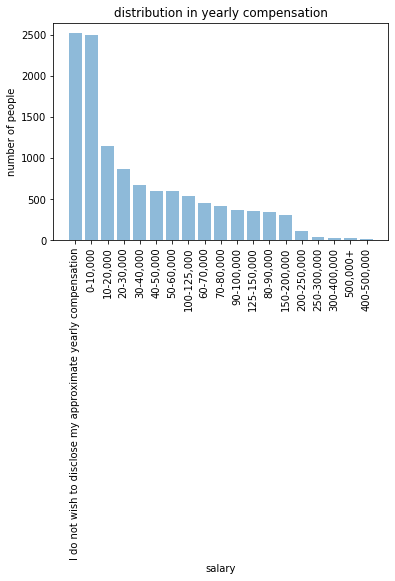

In [8]:
rr = df['Q9'].value_counts()
money = [lis for lis in rr]
#fig, axs = plt.bar(names, height=dis)
plt.bar(rr.index, money, align='center', alpha=0.5)
plt.xticks(rr.index, rotation = 90)
plt.xlabel('salary')
plt.ylabel('number of people')
plt.title('distribution in yearly compensation')

plt.show()

Most people did not provide their yearly salary. Since this column is caterigorical data, I could have filled those with the mode of this column. However, the mode is 0-10,000, and the values in this column is already really screwed and screwed classes can decrease prediction accuracy. So I dropped those entries without actualy salary data. The resulting size looks fine.

In [0]:
#df.dropna(subset=['Q9'],inplace=True) # salary! --- Target!
# df = df[df['Q9']!= "I do not wish to disclose my approximate yearly compensation"]

In [0]:
#df['Q9'].unique()

In [11]:
df['Q9'].replace("I do not wish to disclose my approximate yearly compensation", np.nan, inplace=True)
#df['Q9'].fillna(df['Q9'].mode()[0], inplace=True)
df.dropna(subset=['Q9'],inplace=True)
df.shape

(9406, 20)

Since salary data is really screwed, I combined the some salary categories so that the resulting three class is more evenly distributed.

In [12]:
df_s = df
df_s.shape

(9406, 20)

In [13]:

df_s['Q9'].replace(['10-20,000','20-30,000','30-40,000','40-50,000'], '10-50,000', inplace=True)
df_s['Q9'].replace(['50-60,000','60-70,000','70-80,000','80-90,000','90-100,000','100-125,000', '125-150,000',
                        '150-200,000','200-250,000',
                        '250-300,000', '300-400,000',
                        '400-500,000','500,000+'], '50,000+', inplace=True)
df_s.shape

(9406, 20)

In [0]:
s = df_s['Q9'].value_counts()

In [0]:
dis = [lis for lis in s]

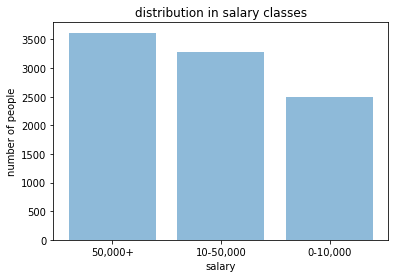

In [16]:
s = df_s['Q9'].value_counts()
dis = [lis for lis in s]
#fig, axs = plt.bar(names, height=dis)
plt.bar(s.index, dis, align='center', alpha=0.5)
plt.xticks(s.index)
plt.xlabel('salary')
plt.ylabel('number of people')
plt.title('distribution in salary classes')

plt.show()

Now the three classes are better distributed.

In [0]:
df=df_s


In [18]:
df.shape

(9406, 20)

In [19]:
df.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11_Part_1,Q11_Part_2,Q11_Part_3,Q11_Part_4,Q11_Part_5,Q11_Part_6,Q12_MULTIPLE_CHOICE,Q17,Q24,Q25
3,Female,30-34,United States of America,Master’s degree,"Computer science (software engineering, etc.)",Data Scientist,I am a student,0-1,"0-10,000",I do not know,Analyze and understand data to influence produ...,NaN,NaN,NaN,NaN,NaN,Local or hosted development environments (RStu...,Java,5-10 years,< 1 year
5,Male,22-24,India,Master’s degree,Mathematics or statistics,Data Analyst,I am a student,0-1,"0-10,000",I do not know,NaN,NaN,NaN,NaN,NaN,NaN,"Advanced statistical software (SPSS, SAS, etc.)",SQL,5-10 years,2-3 years
10,Male,30-34,Hungary,Master’s degree,Engineering (non-computer focused),Software Engineer,Online Service/Internet-based Services,3-4,"10-50,000","We have well established ML methods (i.e., mod...",NaN,Build and/or run a machine learning service th...,Build and/or run the data infrastructure that ...,NaN,NaN,NaN,Local or hosted development environments (RStu...,C#/.NET,1-2 years,< 1 year
14,Male,25-29,United States of America,Bachelor’s degree,Mathematics or statistics,Research Assistant,Academics/Education,1-2,"10-50,000",We are exploring ML methods (and may one day p...,Analyze and understand data to influence produ...,NaN,NaN,Build prototypes to explore applying machine l...,Do research that advances the state of the art...,NaN,Local or hosted development environments (RStu...,Python,3-5 years,1-2 years
17,Male,40-44,Colombia,Master’s degree,Environmental science or geology,Data Scientist,Energy/Mining,1-2,"50,000+",We are exploring ML methods (and may one day p...,NaN,NaN,NaN,Build prototypes to explore applying machine l...,NaN,NaN,Local or hosted development environments (RStu...,R,1-2 years,1-2 years


In [20]:
df.shape

(9406, 20)

One Hot Encoding for Q11: the data has no numerical relationship among them. (the response is already certain 'activities' or NaN. Hence I replaced the activity with 1 and NaN with 0.

In [0]:
df['Q11_Part_1'].replace("Analyze and understand data to influence product or business decisions", 1, inplace=True)
df['Q11_Part_1'].fillna(0, inplace=True)
df['Q11_Part_2'].replace("Build and/or run a machine learning service that operationally improves my product or workflows", 1, inplace=True)
df['Q11_Part_2'].fillna(0, inplace=True)
df['Q11_Part_3'].replace("Build and/or run the data infrastructure that my business uses for storing, analyzing, and operationalizing data", 1, inplace=True)
df['Q11_Part_3'].fillna(0, inplace=True)
df['Q11_Part_4'].replace("Build prototypes to explore applying machine learning to new areas", 1, inplace=True)
df['Q11_Part_4'].fillna(0, inplace=True)
df['Q11_Part_5'].replace("Do research that advances the state of the art of machine learning", 1, inplace=True)
df['Q11_Part_5'].fillna(0, inplace=True)
#df['Q11_Part_6'].replace("Analyze and understand data to influence product or business decisions", 1, inplace=True)
#df['Q11_Part_6'].fillna(0, inplace=True)
df.drop('Q11_Part_6',axis=1, inplace=True)

In [0]:
#df_final['Q9'].value_counts().plot(kind='bar') #salary
df_final=df

####encoding

Q2, 8, 9, 24 are caltegorical data but with relationships among them. The categories are continuously increasing in values. For example, age is categorical in this dataset but '28-25 years old' is less in value than '25-30 years old'. Same for years of experience and salary values. Hence I used label encoding for those columns.

In [0]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [0]:
le_cols = ['Q2','Q8','Q9','Q24']
#df_le = df_final[le_cols].apply(le.fit_transform)
#le_cols=['Q9']


Some of the year range data is very small comapared to others. I combined some values together in order to normalise the data as well as put them in numerical order. For example, years can be '1-2', '2-3' and '10-20', so I combined all data under 10 years to be in a range of '0-10'.

In [0]:
#years of experience
df_final['Q8'].replace(['0-1','1-2','2-3','3-4','4-5','5-10'], '0-10', inplace=True)

df_final['Q24'].replace(['< 1 year', '1-2 years','3-5 years','5-10 years',
       'I have never written code and I do not want to learn',
       'I have never written code but I want to learn'], '0-10 years', inplace=True)

In [26]:
df_final['Q9']

3         0-10,000
5         0-10,000
10       10-50,000
14       10-50,000
17         50,000+
           ...    
23833     0-10,000
23841    10-50,000
23842     0-10,000
23844      50,000+
23855      50,000+
Name: Q9, Length: 9406, dtype: object

In [0]:
df_le = df_final[le_cols].apply(le.fit_transform)

In [28]:
df_le.head()

,Q2,Q8,Q9,Q24
3,3,0,0,0
5,1,0,0,0
10,3,0,1,0
14,2,0,1,0
17,5,0,2,0


As for other categorical columns, the data has no numerical relationship among them. They can be considered true or false for each category. I used one hot encoding for them.

In [29]:
from sklearn.preprocessing import OneHotEncoder
one = OneHotEncoder()
one_cols = ['Q1','Q3','Q4','Q5','Q6','Q7','Q10','Q12_MULTIPLE_CHOICE','Q17']
df_one = pd.get_dummies(df_final[one_cols])
df_one.head()

,Q1_Female,Q1_Male,Q3_Argentina,Q3_Australia,Q3_Austria,Q3_Bangladesh,Q3_Belarus,Q3_Belgium,Q3_Brazil,Q3_Canada,Q3_Chile,Q3_China,Q3_Colombia,Q3_Czech Republic,Q3_Denmark,Q3_Egypt,Q3_Finland,Q3_France,Q3_Germany,Q3_Greece,Q3_Hong Kong (S.A.R.),Q3_Hungary,Q3_I do not wish to disclose my location,Q3_India,Q3_Indonesia,"Q3_Iran, Islamic Republic of...",Q3_Ireland,Q3_Israel,Q3_Italy,Q3_Japan,Q3_Kenya,Q3_Malaysia,Q3_Mexico,Q3_Morocco,Q3_Netherlands,Q3_New Zealand,Q3_Nigeria,Q3_Norway,Q3_Other,Q3_Pakistan,...,Q7_I am a student,Q7_Insurance/Risk Assessment,Q7_Manufacturing/Fabrication,Q7_Marketing/CRM,Q7_Medical/Pharmaceutical,Q7_Military/Security/Defense,Q7_Non-profit/Service,Q7_Online Business/Internet-based Sales,Q7_Online Service/Internet-based Services,Q7_Retail/Sales,Q7_Shipping/Transportation,Q10_I do not know,Q10_No (we do not use ML methods),Q10_We are exploring ML methods (and may one day put a model into production),"Q10_We have well established ML methods (i.e., models in production for more than 2 years)","Q10_We recently started using ML methods (i.e., models in production for less than 2 years)",Q10_We use ML methods for generating insights (but do not put working models into production),"Q12_MULTIPLE_CHOICE_Advanced statistical software (SPSS, SAS, etc.)","Q12_MULTIPLE_CHOICE_Basic statistical software (Microsoft Excel, Google Sheets, etc.)","Q12_MULTIPLE_CHOICE_Business intelligence software (Salesforce, Tableau, Spotfire, etc.)","Q12_MULTIPLE_CHOICE_Cloud-based data software & APIs (AWS, GCP, Azure, etc.)","Q12_MULTIPLE_CHOICE_Local or hosted development environments (RStudio, JupyterLab, etc.)",Q12_MULTIPLE_CHOICE_Other,Q17_Bash,Q17_C#/.NET,Q17_C/C++,Q17_Go,Q17_Java,Q17_Javascript/Typescript,Q17_Julia,Q17_MATLAB,Q17_Other,Q17_PHP,Q17_Python,Q17_R,Q17_Ruby,Q17_SAS/STATA,Q17_SQL,Q17_Scala,Q17_Visual Basic/VBA
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
10,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
17,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [0]:
#df_one_1.sum()
#sum_n = df_one_1.sum()
#more = [n for n in sum_n if n<200]

Since there are a lot country with not significant amount of people, i dropped country features with less than 200 people as they can be noise for the model prediction.

In [0]:
df_one = df_one.loc[:, (df_one.sum() >= 200)]

In [32]:
df_one.shape

(9406, 70)

Again dropping columns that do not contain useful information.

In [0]:
#df_one.drop('Q3_I do not wish to disclose my location',axis=1, inplace=True)
#df_one.drop('Q4_I prefer not to answer',axis=1, inplace=True)
df_one.drop('Q10_I do not know',axis=1, inplace=True)
df_one.drop('Q3_Other',axis=1, inplace=True)
df_one.drop('Q12_MULTIPLE_CHOICE_Other',axis=1, inplace=True)

In [0]:
#one.fit_transform(df_final[one_cols])

Concatenate label endoding df and on hot encoding df.

In [0]:
#no Q11_part_1 to 5
df_clean = pd.concat([df_le, df_one], axis=1)

In [36]:
df_clean.head()

,Q2,Q8,Q9,Q24,Q1_Female,Q1_Male,Q3_Brazil,Q3_Canada,Q3_China,Q3_France,Q3_Germany,Q3_India,Q3_Japan,Q3_Russia,Q3_Spain,Q3_United Kingdom of Great Britain and Northern Ireland,Q3_United States of America,Q4_Bachelor’s degree,Q4_Doctoral degree,Q4_Master’s degree,Q4_Professional degree,Q4_Some college/university study without earning a bachelor’s degree,"Q5_A business discipline (accounting, economics, finance, etc.)","Q5_Computer science (software engineering, etc.)",Q5_Engineering (non-computer focused),"Q5_Information technology, networking, or system administration",Q5_Mathematics or statistics,"Q5_Medical or life sciences (biology, chemistry, medicine, etc.)",Q5_Physics or astronomy,"Q5_Social sciences (anthropology, psychology, sociology, etc.)",Q6_Business Analyst,Q6_Consultant,Q6_Data Analyst,Q6_Data Engineer,Q6_Data Scientist,Q6_Manager,Q6_Research Assistant,Q6_Research Scientist,Q6_Software Engineer,Q6_Student,Q7_Academics/Education,Q7_Accounting/Finance,Q7_Broadcasting/Communications,Q7_Computers/Technology,Q7_Energy/Mining,Q7_Government/Public Service,Q7_I am a student,Q7_Insurance/Risk Assessment,Q7_Manufacturing/Fabrication,Q7_Marketing/CRM,Q7_Medical/Pharmaceutical,Q7_Online Service/Internet-based Services,Q7_Retail/Sales,Q10_No (we do not use ML methods),Q10_We are exploring ML methods (and may one day put a model into production),"Q10_We have well established ML methods (i.e., models in production for more than 2 years)","Q10_We recently started using ML methods (i.e., models in production for less than 2 years)",Q10_We use ML methods for generating insights (but do not put working models into production),"Q12_MULTIPLE_CHOICE_Advanced statistical software (SPSS, SAS, etc.)","Q12_MULTIPLE_CHOICE_Basic statistical software (Microsoft Excel, Google Sheets, etc.)","Q12_MULTIPLE_CHOICE_Business intelligence software (Salesforce, Tableau, Spotfire, etc.)","Q12_MULTIPLE_CHOICE_Cloud-based data software & APIs (AWS, GCP, Azure, etc.)","Q12_MULTIPLE_CHOICE_Local or hosted development environments (RStudio, JupyterLab, etc.)",Q17_C#/.NET,Q17_C/C++,Q17_Java,Q17_Javascript/Typescript,Q17_MATLAB,Q17_Python,Q17_R,Q17_SQL
3,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
5,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
10,3,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
14,2,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
17,5,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0


In [37]:
df_clean.shape

(9406, 71)

### 2.Exploratory data analysis (15 marks):
a.Present 3 graphical figures that represent trends in the data. How could these trends be used to help  with  the  task  of  predicting yearly  compensation  or  understanding  the  data?  All  graphs should be readableand presented in the notebook. All axes must be appropriately labelled. 

b.Visualize the order of feature importance. Some possible methods include correlation plot, or a similar method. Given the data, which of the original attributes in the data are most related to a survey respondent’s yearly compensation?

In [0]:
y = df_clean['Q9']
x = df_clean.loc[:, df_clean.columns != 'Q9']

#####The difference in yearly compensation between males and females.
In general female employees are less than male employees and the yearly compemsation for females seems lower than males. Hence it implies that gender is a possible factor influencing compensation.



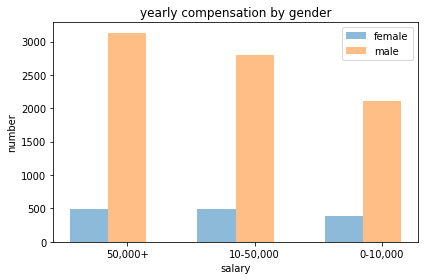

In [39]:
female = df_clean[df_clean['Q1_Female']==1].Q9.value_counts()
male = df_clean[df_clean['Q1_Male']==1].Q9.value_counts()

n_groups = 3

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.3
opacity = 0.5

rects1 = plt.bar(index, female, bar_width,
alpha=opacity,
label='female')

rects2 = plt.bar(index + bar_width, male, bar_width,
alpha=opacity,
label='male')

plt.xlabel('salary')
plt.ylabel('number')
plt.title('yearly compensation by gender')
plt.xticks(index + bar_width, s.index)
plt.legend()

plt.tight_layout()
plt.show()

In [0]:
#coutry
country = df_clean.loc[:, ['Q3_Brazil', 'Q3_Canada', 'Q3_China', 'Q3_France', 'Q3_Germany',
       'Q3_India', 'Q3_Japan', 'Q3_Russia', 'Q3_Spain',
       'Q3_United Kingdom of Great Britain and Northern Ireland',
       'Q3_United States of America']]
#country.sum().plot(kind='bar',figsize=(10,6))

####The difference in countries of origin.
China, India and USA are the top three countries with the most number of responses from data analyst, It could imply that education in three countries is more suitable for data analysis, hence would affect how companies will pay to the people from different countries.

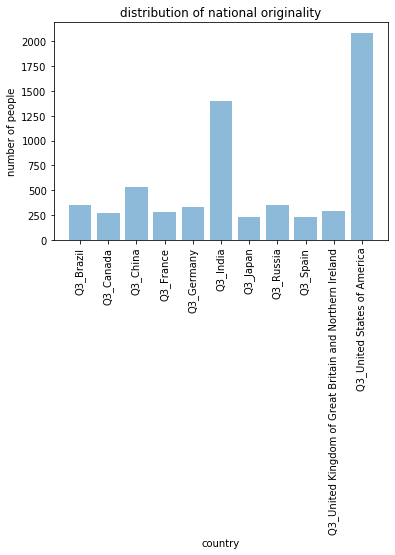

In [41]:
xax = country.columns
yax = country.sum()
#fig, axs = plt.bar(names, height=dis)
plt.bar(xax, yax, align='center', alpha=0.5, width=0.8)
plt.rcParams["figure.figsize"] = [15,6]
plt.xticks(xax, rotation=90)
plt.xlabel('country')
plt.ylabel('number of people')
plt.title('distribution of national originality')

plt.show()

#### Education background:
The majority of the respondents have Doctoral or Masters in Computer Science, Engineering or Math/Statistics programs. People from these educational background are more likely to take data analysis jobs. Education background could be important in the skill level of data jobs and related to salaries.

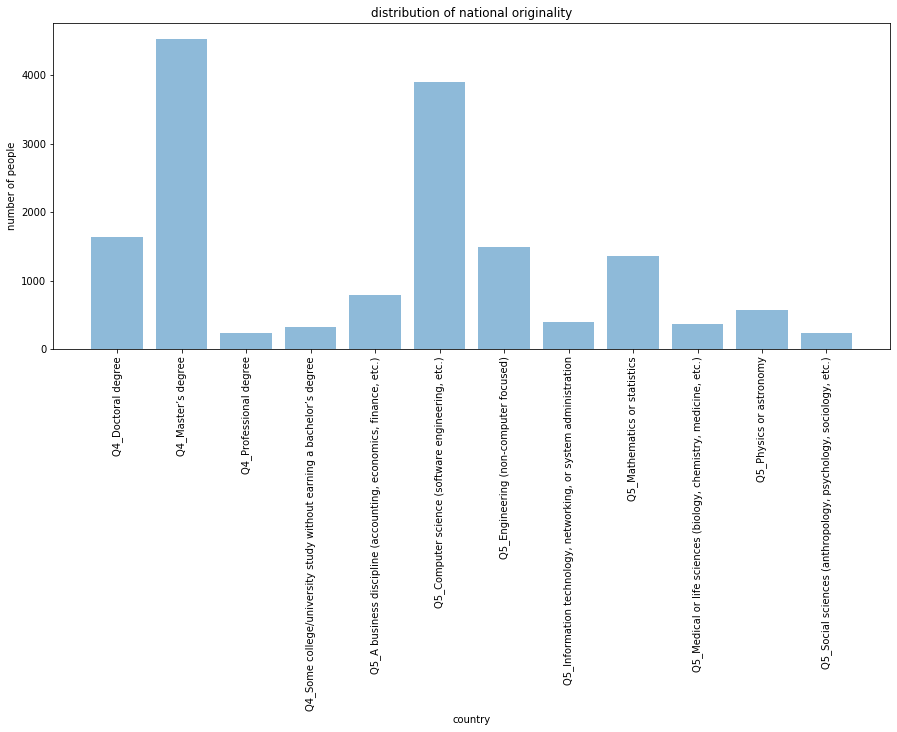

In [42]:
degree = x.loc[:,['Q4_Doctoral degree', 'Q4_Master’s degree', 'Q4_Professional degree',
       'Q4_Some college/university study without earning a bachelor’s degree','Q5_A business discipline (accounting, economics, finance, etc.)',
       'Q5_Computer science (software engineering, etc.)',
       'Q5_Engineering (non-computer focused)',
       'Q5_Information technology, networking, or system administration',
       'Q5_Mathematics or statistics',
       'Q5_Medical or life sciences (biology, chemistry, medicine, etc.)',
       'Q5_Physics or astronomy',
       'Q5_Social sciences (anthropology, psychology, sociology, etc.)']]
#degree.sum().plot(kind='bar')
xax = degree.columns
yax = degree.sum()
#fig, axs = plt.bar(names, height=dis)
plt.bar(xax, yax, align='center', alpha=0.5, width=0.8)
plt.rcParams["figure.figsize"] = [15,6]
plt.xticks(xax, rotation=90)
plt.xlabel('country')
plt.ylabel('number of people')
plt.title('distribution of national originality')

plt.show()

Majority of people are data analysts or data scientists in computer/technology, software engineering and still in school.

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


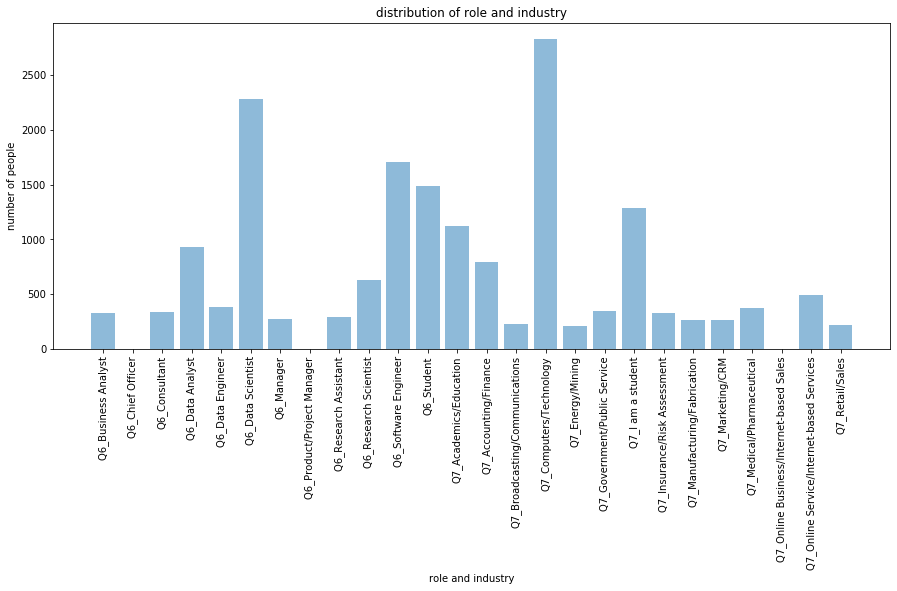

In [43]:
industry = x.loc[:,['Q6_Business Analyst', 'Q6_Chief Officer', 'Q6_Consultant',
       'Q6_Data Analyst', 'Q6_Data Engineer', 'Q6_Data Scientist',
       'Q6_Manager', 'Q6_Product/Project Manager', 'Q6_Research Assistant',
       'Q6_Research Scientist', 'Q6_Software Engineer', 'Q6_Student',
       'Q7_Academics/Education', 'Q7_Accounting/Finance',
       'Q7_Broadcasting/Communications', 'Q7_Computers/Technology',
       'Q7_Energy/Mining', 'Q7_Government/Public Service', 'Q7_I am a student',
       'Q7_Insurance/Risk Assessment', 'Q7_Manufacturing/Fabrication',
       'Q7_Marketing/CRM', 'Q7_Medical/Pharmaceutical',
       'Q7_Online Business/Internet-based Sales',
       'Q7_Online Service/Internet-based Services', 'Q7_Retail/Sales']]
xax = industry.columns
yax = industry.sum()
#fig, axs = plt.bar(names, height=dis)
plt.bar(xax, yax, align='center', alpha=0.5, width=0.8)
plt.rcParams["figure.figsize"] = [15,6]
plt.xticks(xax, rotation=90)
plt.xlabel('role and industry')
plt.ylabel('number of people')
plt.title('distribution of role and industry')

plt.show()

Most people use local/hosted development environment, and Python is the number one programming language used in data analysis.

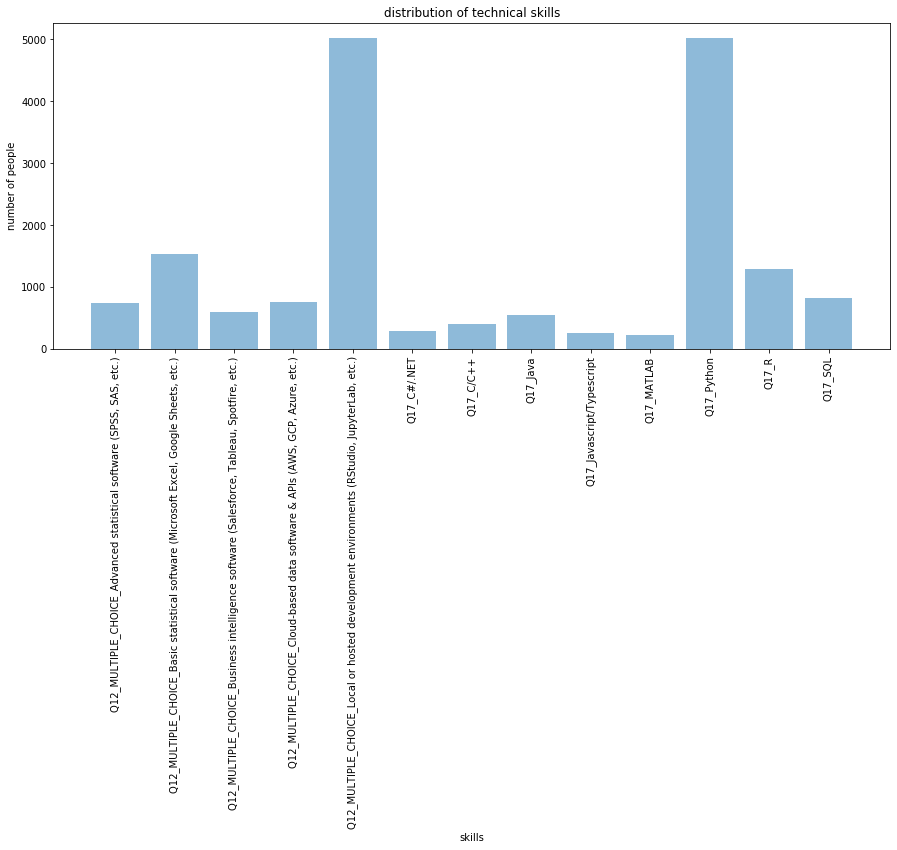

In [44]:
skill = x.loc[:,['Q12_MULTIPLE_CHOICE_Advanced statistical software (SPSS, SAS, etc.)',
       'Q12_MULTIPLE_CHOICE_Basic statistical software (Microsoft Excel, Google Sheets, etc.)',
       'Q12_MULTIPLE_CHOICE_Business intelligence software (Salesforce, Tableau, Spotfire, etc.)',
       'Q12_MULTIPLE_CHOICE_Cloud-based data software & APIs (AWS, GCP, Azure, etc.)',
       'Q12_MULTIPLE_CHOICE_Local or hosted development environments (RStudio, JupyterLab, etc.)',
       'Q17_C#/.NET', 'Q17_C/C++', 'Q17_Java',
       'Q17_Javascript/Typescript', 'Q17_MATLAB', 'Q17_Python', 'Q17_R',
       'Q17_SQL']]
xax = skill.columns
yax = skill.sum()
#fig, axs = plt.bar(names, height=dis)
plt.bar(xax, yax, align='center', alpha=0.5, width=0.8)
plt.rcParams["figure.figsize"] = [15,6]
plt.xticks(xax, rotation=90)
plt.xlabel('skills')
plt.ylabel('number of people')
plt.title('distribution of technical skills')

plt.show()

###3. Feature selection (10 marks):
Not all features need to be used; features can be removed or added as desired. If the resulting number of features is very high, dimensionality reduction can also be used (e.g. PCA). Use at least one feature selection technique – describe the technique and provide justification on why you selected that set of features.

Feature engineering is a useful tool in machine learning, because we try to predict target class based on features and good feature selection and feature engineering can help us achieve high prediction accuracy.

First I looked at the correlation of different features and the target salary class. The more correlated features are more likely to influence the classification prediction.

In [0]:
XY = pd.concat([x,y], axis=1)

In [46]:
#correlation matrix
import seaborn as sns

rs = np.random.RandomState(0)
#df = pd.DataFrame(rs.rand(10, 10))
corr = XY.corr()
corr.style.background_gradient(cmap=sns.diverging_palette(220, 10, as_cmap=True))
# 'RdBu_r' & 'BrBG' are other good diverging colormaps

If we look at the last row or the last column, darker colour cells are features that are highly correlated. They are also printed below. The following features are mostly correlated to the target.

In [47]:
corr = df_clean[df_clean.columns[1:]].corr()['Q9']
corr.sort_values(ascending=False)

Q9                                                                                            1.000000
Q3_United States of America                                                                   0.386279
Q24                                                                                           0.235642
Q6_Data Scientist                                                                             0.212073
Q10_We have well established ML methods (i.e., models in production for more than 2 years)    0.204667
                                                                                                ...   
Q4_Bachelor’s degree                                                                         -0.181188
Q5_Computer science (software engineering, etc.)                                             -0.191245
Q3_India                                                                                     -0.316513
Q7_I am a student                                                        

I also used the following RFECV algorithm with 10-fold cross validation to select the most relevant features suited to a logistic regression model. 
This technique run over 10 fold cross validation and determines the optimal number of features to include in the model (and plots a curve to illustrate this). Features selected by correlation method also overlaps the results from this function. So the selected featres are good features to make accurate model prediction.

In [48]:
from sklearn.feature_selection import RFECV
from sklearn import datasets, linear_model
from sklearn.svm import SVR

import warnings
#warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore")

#X, y = make_friedman1(n_samples=50, n_features=10, random_state=0)
# Create a logistic regression
lrf = linear_model.LogisticRegression(solver='liblinear', C=0.1) # solver='lbfgs',

rfecv = RFECV(estimator=lrf, step=1, cv=10) #scoring='neg_mean_squared_error')

# Fit recursive feature eliminator 
rfecv.fit(x, y)

# Recursive feature elimination
#rfecv.transform(x)

RFECV(cv=10,
      estimator=LogisticRegression(C=0.1, class_weight=None, dual=False,
                                   fit_intercept=True, intercept_scaling=1,
                                   l1_ratio=None, max_iter=100,
                                   multi_class='warn', n_jobs=None,
                                   penalty='l2', random_state=None,
                                   solver='liblinear', tol=0.0001, verbose=0,
                                   warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring=None, step=1, verbose=0)

Optimal number of features : 46


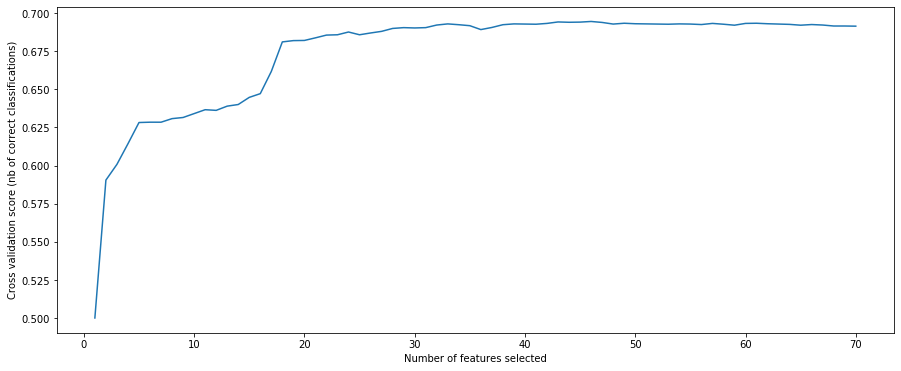

In [49]:
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [0]:
n = rfecv.n_features_
w = sorted(list(zip(rfecv.ranking_, x)))
features = [lis[1] for lis in w[:n]]

###4. Model implementation (25 marks):
Implement logistic regression algorithm on the training data using 10-fold cross-validation. How does your model accuracy compare across the folds? 
What is average and variance of accuracy for folds? 

Treating each value of hyperparameter(s) as a new model, which model performed best? Give the reason based on bias-variance trade-off.

 An output of your algorithm should be a probability of belonging to each of the salary buckets. Apply scaling/normalization of features, if necessary.

In [0]:
X_df = x.loc[:,features]
y_df = y
#train test split
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, random_state=50, test_size=0.3)

first, without cross validation

In [52]:
model = LogisticRegression()    
#fit lr
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
#predict test set
y_pred = model.predict(X_test)

In [54]:
#accuracy score
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.6885187810063784

In [0]:
#TN = confusion_matrix(y_test, y_pred)[0][0]
#FP = confusion_matrix(y_test, y_pred)[0][1]
#FN = confusion_matrix(y_test, y_pred)[1][0]
#TP = confusion_matrix(y_test, y_pred)[1][1]
#total = TN + FP + FN + TP
#ACC = (TP + TN) / float(total)

#print ("This model got an accuracy of {}% on the testing set".format(round(ACC*100,2)))  

In [0]:
# score for train and set sets
lr_score_train = model.score(X_train, y_train)
lr_score_test = model.score(X_test, y_test)

In [57]:
print ('Accuracy of logisitic regression classifier on the train set:{:.2f}'.format(model.score(X_train, y_train)))
print ('Accuracy of logisitic regression classifier on the test set:{:.2f}'.format
       (model.score(X_test, y_test)))

Accuracy of logisitic regression classifier on the train set:0.71
Accuracy of logisitic regression classifier on the test set:0.69


#### Logistic Regression with 10-fold cross validation

In [58]:
model_cv = LogisticRegression()
scaler = StandardScaler()
kfold = KFold(n_splits=10)
kfold.get_n_splits(X_df)

accuracy = np.zeros(10)
np_idx = 0

for train_idx, test_idx in kfold.split(X_df):
    X_train, X_test = X_df.values[train_idx], X_df.values[test_idx]
    y_train, y_test = y_df.values[train_idx], y_df.values[test_idx]
    
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    model_cv.fit(X_train, y_train)
    
    y_pred = model_cv.predict(X_test)
    
    #TN = confusion_matrix(y_test, predictions)[0][0]
    #FP = confusion_matrix(y_test, predictions)[0][1]
    #FN = confusion_matrix(y_test, predictions)[1][0]
    #TP = confusion_matrix(y_test, predictions)[1][1]
    #total = TN + FP + FN + TP
    #ACC = (TP + TN) / float(total)
    ACC = model_cv.score(X_train, y_train)
    #cv_score_test = model_cv.score(X_test, y_test)
    accuracy[np_idx] = ACC*100
    np_idx += 1
    
    print ("Fold {}: Accuracy: {}%".format(np_idx, round(ACC,3)))   

print ("Average Score: {}% (variance:{}%)".format(round(np.mean(accuracy),3),round(np.var(accuracy),3)))

Fold 1: Accuracy: 0.705%
Fold 2: Accuracy: 0.705%
Fold 3: Accuracy: 0.699%
Fold 4: Accuracy: 0.707%
Fold 5: Accuracy: 0.704%
Fold 6: Accuracy: 0.702%
Fold 7: Accuracy: 0.707%
Fold 8: Accuracy: 0.705%
Fold 9: Accuracy: 0.699%
Fold 10: Accuracy: 0.712%
Average Score: 70.474% (variance:0.129%)


In [0]:
#cv lr scores for train and test
cv_score_train = model_cv.score(X_train, y_train)
cv_score_test = model_cv.score(X_test, y_test)

####Mean accuracy across 10 folds are 70.47%, with variance of 0.129%

#### The following output of logistic regression computes a probability of belonging to each of the salary classes. 

In [60]:
#predict probability of belong to certain target class
model.predict_proba(X_train)

array([[6.43398067e-01, 2.27948543e-03, 3.54322448e-01],
       [8.48670546e-01, 1.51320212e-01, 9.24203850e-06],
       [1.42049001e-01, 3.95752222e-01, 4.62198777e-01],
       ...,
       [5.41590601e-05, 1.67657310e-01, 8.32288531e-01],
       [5.97365536e-01, 3.66689862e-01, 3.59446013e-02],
       [5.04955930e-01, 4.94495879e-01, 5.48191447e-04]])

In [0]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1,\
                        train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy'):
    
    plt.figure(figsize=(10,6))
    plt.title(title)
    
    if ylim is not None:
        plt.ylim(*ylim)
        
    plt.xlabel("Training examples")
    plt.ylabel(scoring)
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,\
                     train_scores_mean + train_scores_std, alpha=0.1, \
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,\
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

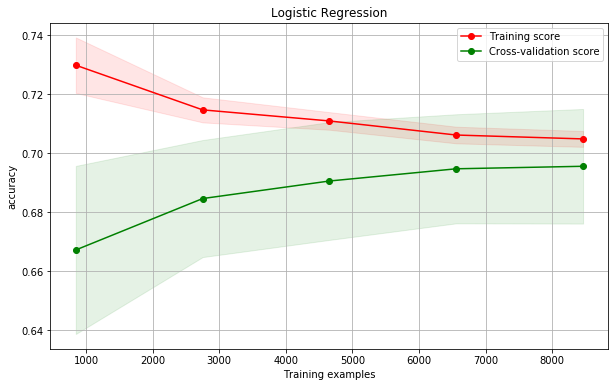

In [62]:
plot_learning_curve(model,'Logistic Regression', X_df, y_df, cv=10)

####Bias-variance trade-off
If bias and variance curves are “close to each other” and both of them but have a low score. The model suffer from an under fitting problem (High Bias). A high bias problem has the following characteristics:High training error, and validation error is similar in magnitude to the training error.

If training curve has a much better score but testing curve has a lower score, i.e., there are large gaps between two curves. Then the model suffer from an over fitting problem (High Variance). A high variance problem on the other hand has the following characteristics: low training error, and very high Validation error.

With cross-validation, a learning curve shows the relationship of the training score vs the cross validated test score for an estimator with a varying number of training samples. If the training error is high, it means that the training data is not fitted well enough by the estimated model. If the model fails to fit the training data well, it means it has high bias with respect to that set of data. A narrow gap indicates low variance. Generally, the more narrow the gap, the lower the variance. The opposite is also true: the wider the gap, the greater the variance. 

When the two curves converge, the model achieved optimal trade-off.

### 5. Model tuning (20 marks):
Improve the performance of the models from the previous step with hyperparameter tuning and select a final optimal model using grid search based on a metric (or metrics) that you choose. Choosing an optimal model for a given task (comparing multiple classifiers on a specific domain) requires selecting performance measures, for example accuracy, precision, recall and/or F1-score to compare the model performance.
There is no minimum model accuracy, as long as your methodology is reasonable and well explained.

Using Grid Search, the hyperparameter of logistic regression the the regularizatino parameter C. in the GV, I searched L1, L2 regulirisation, C. The solver used is liblinear since this problem is multiclass classification. Due to the same reason, accuracy is used as the metric because accuracy can effectively measure whether the prediction is right and the other metrics such as precision, recall and F1 can be only used in binary problems.

In [0]:
from sklearn.model_selection import GridSearchCV
param_grid = {'penalty' : ['l1', 'l2'],
              'C':[0.1, 1, 10,20,50],
              'solver' : ['liblinear']}

# Create grid search object
lr = LogisticRegression()
grdlr = GridSearchCV(estimator = lr, param_grid = param_grid, cv = 10)

# Fit on data
best_lr = grdlr.fit(X_train, y_train)

####The best model have the following parameters, by Grid Search.

In [64]:
#parameter results for grid search
grdlr.best_params_

{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}

The best accuracy score achieved in grid search is the following:

In [65]:
#cross_validation score
grdlr.best_score_

0.7024568863690054

###6. Testing & Discussion (10 marks):
Use your optimal model to make classifications on the test set. How does your model perform on the test set vs. the training set? The overall fit of the model, how to increase the accuracy (test, training)? Is it overfitting or underfitting? Why? Plot the distribution.
Insufficient discussion will lead to the deduction on marks.

In [66]:
#predict test set and get accuracy score
y_pred_2 = best_lr.predict(X_test)
score_test = best_lr.score(X_test, y_test) #best model test acore
print('The accuracy score on test set in {}'.format(score_test))

The accuracy score on test set in 0.6414893617021277


The model performs better on train set than test set. There is a little overfitting but the difference is not large, then it is okay. 

The model performs better well in overall, because this three-class problem has a baseline accuracy of 0.3333 (randonly guessing), and the model accuracy is a lot higher than that.

In [0]:
# computue accuracy for train and test
best_score_train = best_lr.score(X_train,y_train)
best_score_test = best_lr.score(X_test,y_test)

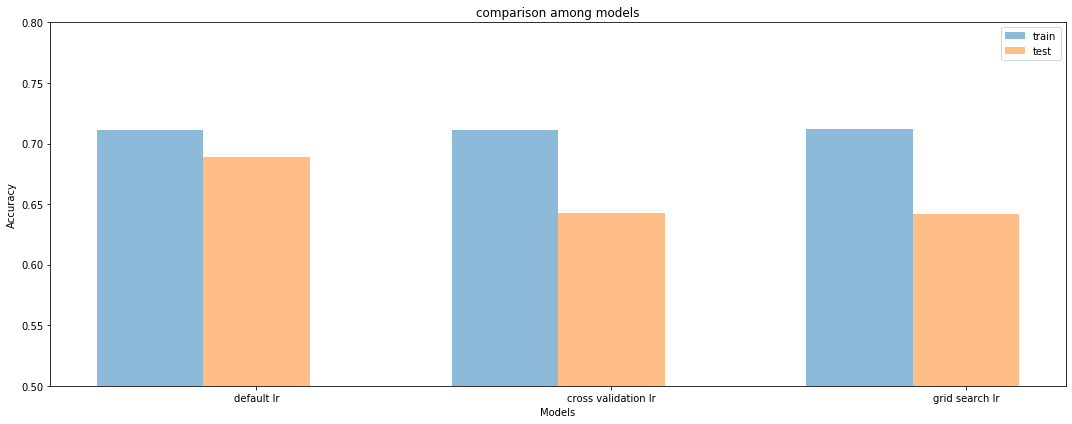

In [68]:
#lr = [lr_score_train, lr_score_test]
#cvlr = [lr_score_train, cv_score_test]
#gslr = [best_score_train, best_score_test]
score_train = [lr_score_train,lr_score_train,best_score_train]
score_test = [lr_score_test, cv_score_test, best_score_test]

n_groups = 3

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.3
opacity = 0.5

rects1 = plt.bar(index, score_train, bar_width,
alpha=opacity,
label='train')

rects2 = plt.bar(index + bar_width, score_test, bar_width,
alpha=opacity,
label='test')

#rects3 = plt.bar(index+2*bar_width, gslr ,bar_width,
#alpha=opacity,
#label='GridSearch')

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('comparison among models')
plt.xticks(index + bar_width, ['default lr', 'cross validation lr','grid search lr'])
ax = plt.gca()
ax.set_ylim([0.5,0.8])
plt.legend()

plt.tight_layout()
plt.show()

In order to increase accuracy, regularisation is used and we can do another round of feature selection and feature engineering. In addition, we can look at the data distributions adn remove some noise data to prevent overfitting. 

In [70]:
score_train

[0.7108140947752126, 0.7108140947752126, 0.7117883297897473]

In [71]:
score_test

[0.6885187810063784, 0.6425531914893617, 0.6414893617021277]

####Discussion


In [69]:
#print feature selected
features

['Q10_No (we do not use ML methods)',
 'Q10_We are exploring ML methods (and may one day put a model into production)',
 'Q10_We have well established ML methods (i.e., models in production for more than 2 years)',
 'Q10_We recently started using ML methods (i.e., models in production for less than 2 years)',
 'Q10_We use ML methods for generating insights (but do not put working models into production)',
 'Q12_MULTIPLE_CHOICE_Basic statistical software (Microsoft Excel, Google Sheets, etc.)',
 'Q12_MULTIPLE_CHOICE_Cloud-based data software & APIs (AWS, GCP, Azure, etc.)',
 'Q17_MATLAB',
 'Q17_SQL',
 'Q1_Female',
 'Q1_Male',
 'Q2',
 'Q24',
 'Q3_Brazil',
 'Q3_Canada',
 'Q3_China',
 'Q3_France',
 'Q3_Germany',
 'Q3_India',
 'Q3_Japan',
 'Q3_Russia',
 'Q3_Spain',
 'Q3_United Kingdom of Great Britain and Northern Ireland',
 'Q3_United States of America',
 'Q4_Bachelor’s degree',
 'Q4_Doctoral degree',
 'Q4_Professional degree',
 'Q4_Some college/university study without earning a bachelor’

When trying to determine the yearly compensation for data related jobs, the features in the above list worth some attention. Company's data analysis methodology, Technical skills, Country of origin, Eduction background, and your job responsibility and the industry you are working in all play some role in determing whether you can get a high yearly compensation. 

In the meantime, let us hope that gender is not an important feature and try to encourage more female to take data related roles in the workplace. If more women work in related data fields, more female responses can be obtained in the survey and we can really look at whether there is indeed some extent of gender difference in the data science community.